In this notebook we will use the nn class **Sequential** to model a CNN

We will use the single target network

# Import

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import KFold

from tqdm import tqdm

import load_script
from params import *
from custom_layers import *
from training import *
from networks import *
from result import *

from utilities import *
from parse_dataset import *

In [2]:
%load_ext autoreload
%autoreload 2

# Loading the dataset

In [3]:
folder=Dataset(base_directory='/home/stefano/',dataset='eeg')

Reading data from /home/stefano/EEG//
Reading data from /home/stefano/EEG//stored//
Reading data from /home/stefano/EEG//__pycache__//
Reading data from /home/stefano/EEG//data//
Reading data from /home/stefano/EEG//stefano//
Reading data from /home/stefano/EEG//stefano//figures//
Reading data from /home/stefano/EEG//stefano//__pycache__//
Reading data from /home/stefano/EEG//stefano//notebook//


In [ ]:
train_dataset,train_target=load_script.load_dataset_1000hz(train=True)

In [ ]:
test_dataset,test_target=load_script.load_dataset_1000hz(train=False)

In [4]:
train_dataset,train_target=load_script.load_dataset(train=True)

In [5]:
test_dataset,test_target=load_script.load_dataset(train=False)

In [6]:
train_ds = []
train_ds.append(train_dataset.data.numpy())
for i in range(4):
    train_ds.append(train_ds[0] + np.random.normal(scale = 0.5, size = train_ds[0].shape))

train_ds = np.asarray(train_ds).reshape(316 * 5, 28, 50)

train_dataset = Variable(torch.FloatTensor(train_ds))
train_target = Variable(torch.LongTensor(np.tile(train_target.data.numpy().T, 5).T)) #Repeat target values

# Normalization

In [7]:
train_dataset.shape

torch.Size([1580, 28, 50])

In [8]:
test_dataset.shape

torch.Size([100, 28, 50])

In [9]:
mean=train_dataset.mean(0).mean(1).view(1,28,1)
std=train_dataset.std(2).mean(0).view(1,28,1)

In [10]:
train_dataset=(train_dataset-mean)/std
test_dataset=(test_dataset-mean)/std

# Defining the network

### Simple Network

# Training

Dropout 0


/home/stefano/anaconda3/lib/python3.6/site-packages/torch/cuda/__init__.py:97: UserWarning: 
    Found GPU0 GeForce GTX 960M which is of cuda capability 5.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


ThreeCNNLayers(
  (sequential): Sequential(
    (0): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): Dropout(p=0)
    (4): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (5): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (6): ReLU()
    (7): Dropout(p=0)
    (8): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (9): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (10): ReLU()
    (11): Dropout(p=0)
    (12): Flatten(
    )
    (13): Linear(in_features=1232, out_features=200, bias=True)
    (14): ReLU()
    (15): Linear(in_features=200, out_features=2, bias=True)
  )
)


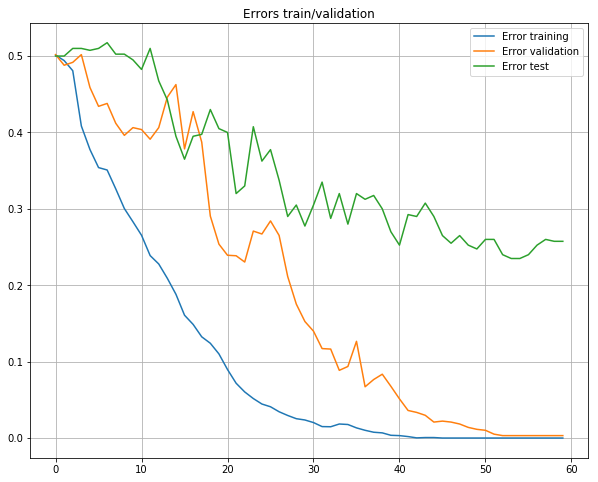

Error train: 0.0
Error validation: 0.00848101265823
Error test: 0.252166666667
Dropout 0.1
ThreeCNNLayers(
  (sequential): Sequential(
    (0): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): Dropout(p=0.1)
    (4): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (5): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (6): ReLU()
    (7): Dropout(p=0.1)
    (8): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (9): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (10): ReLU()
    (11): Dropout(p=0.1)
    (12): Flatten(
    )
    (13): Linear(in_features=1232, out_features=200, bias=True)
    (14): ReLU()
    (15): Linear(in_features=200, out_features=2, bias=True)
  )
)


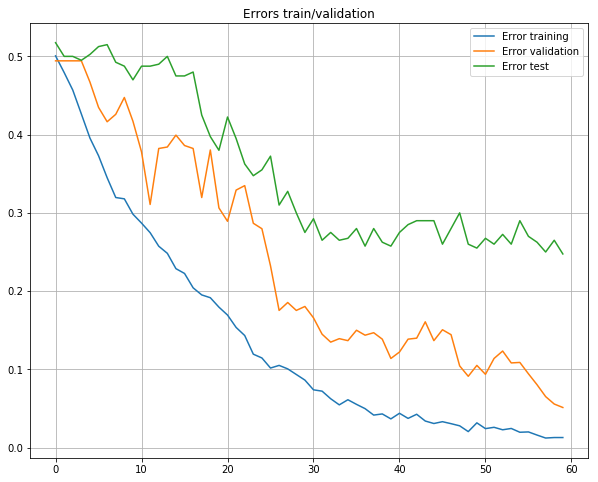

Error train: 0.0223206751055
Error validation: 0.0993670886076
Error test: 0.266666666667
Dropout 0.2
ThreeCNNLayers(
  (sequential): Sequential(
    (0): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): Dropout(p=0.2)
    (4): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (5): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (6): ReLU()
    (7): Dropout(p=0.2)
    (8): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (9): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (10): ReLU()
    (11): Dropout(p=0.2)
    (12): Flatten(
    )
    (13): Linear(in_features=1232, out_features=200, bias=True)
    (14): ReLU()
    (15): Linear(in_features=200, out_features=2, bias=True)
  )
)


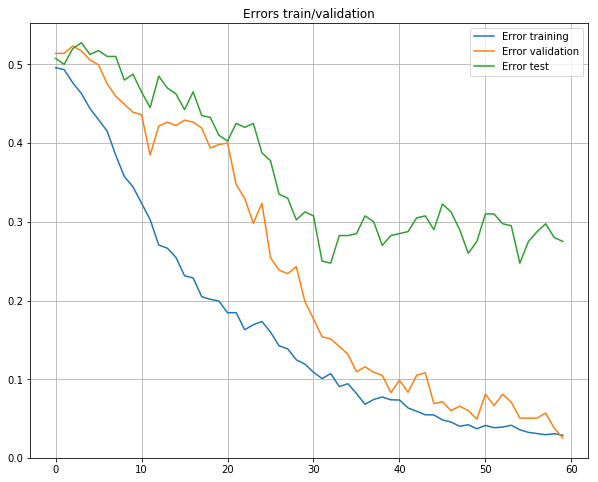

Error train: 0.0375105485232
Error validation: 0.0585654008439
Error test: 0.289
Dropout 0.3
ThreeCNNLayers(
  (sequential): Sequential(
    (0): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): Dropout(p=0.3)
    (4): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (5): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (6): ReLU()
    (7): Dropout(p=0.3)
    (8): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (9): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (10): ReLU()
    (11): Dropout(p=0.3)
    (12): Flatten(
    )
    (13): Linear(in_features=1232, out_features=200, bias=True)
    (14): ReLU()
    (15): Linear(in_features=200, out_features=2, bias=True)
  )
)


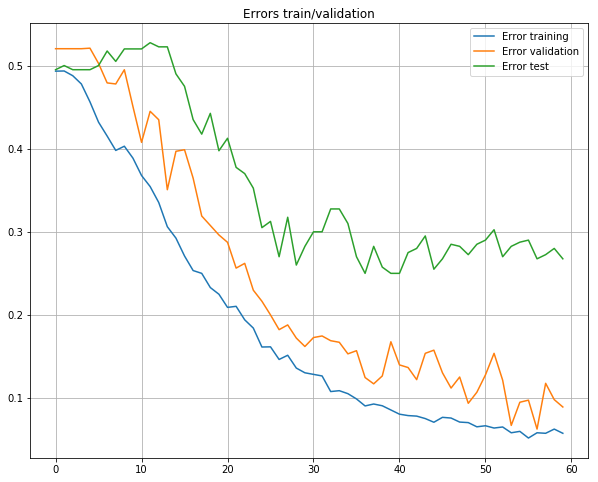

Error train: 0.0641068917018
Error validation: 0.106582278481
Error test: 0.280166666667
Dropout 0.4
ThreeCNNLayers(
  (sequential): Sequential(
    (0): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): Dropout(p=0.4)
    (4): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (5): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (6): ReLU()
    (7): Dropout(p=0.4)
    (8): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (9): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (10): ReLU()
    (11): Dropout(p=0.4)
    (12): Flatten(
    )
    (13): Linear(in_features=1232, out_features=200, bias=True)
    (14): ReLU()
    (15): Linear(in_features=200, out_features=2, bias=True)
  )
)


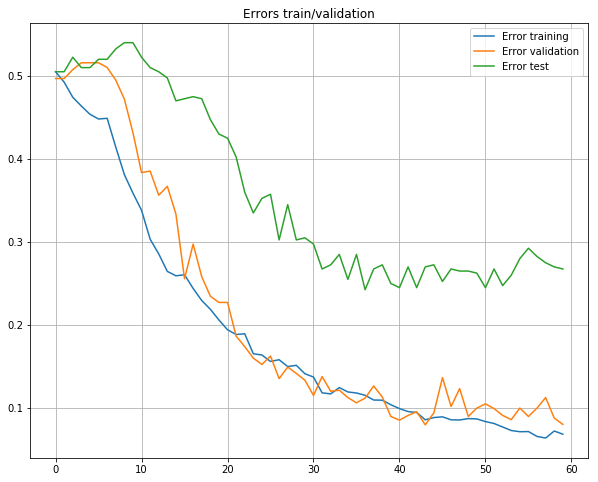

Error train: 0.0776371308017
Error validation: 0.10029535865
Error test: 0.266666666667
Dropout 0.5
ThreeCNNLayers(
  (sequential): Sequential(
    (0): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): Dropout(p=0.5)
    (4): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (5): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (6): ReLU()
    (7): Dropout(p=0.5)
    (8): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (9): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (10): ReLU()
    (11): Dropout(p=0.5)
    (12): Flatten(
    )
    (13): Linear(in_features=1232, out_features=200, bias=True)
    (14): ReLU()
    (15): Linear(in_features=200, out_features=2, bias=True)
  )
)


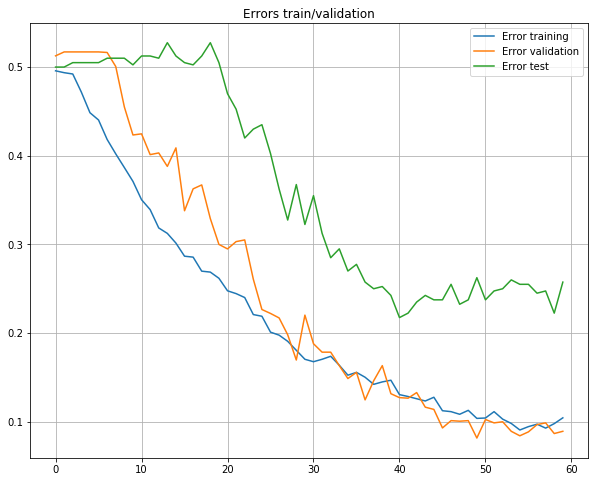

Error train: 0.10288326301
Error validation: 0.0941772151899
Error test: 0.246833333333
Dropout 0.6
ThreeCNNLayers(
  (sequential): Sequential(
    (0): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): Dropout(p=0.6)
    (4): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (5): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (6): ReLU()
    (7): Dropout(p=0.6)
    (8): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (9): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (10): ReLU()
    (11): Dropout(p=0.6)
    (12): Flatten(
    )
    (13): Linear(in_features=1232, out_features=200, bias=True)
    (14): ReLU()
    (15): Linear(in_features=200, out_features=2, bias=True)
  )
)


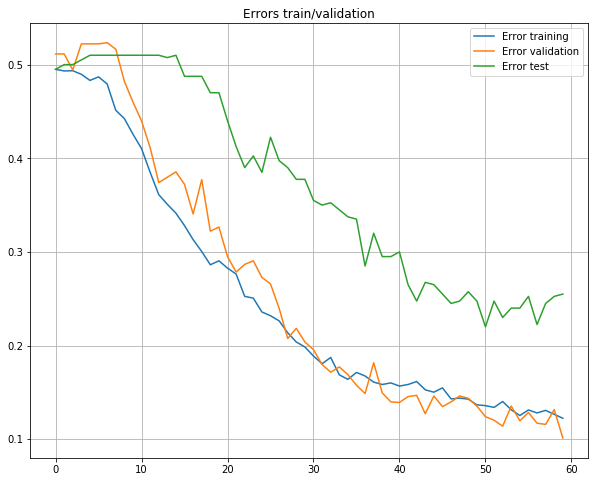

Error train: 0.135147679325
Error validation: 0.127172995781
Error test: 0.243833333333
Dropout 0.7
ThreeCNNLayers(
  (sequential): Sequential(
    (0): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): Dropout(p=0.7)
    (4): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (5): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (6): ReLU()
    (7): Dropout(p=0.7)
    (8): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (9): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (10): ReLU()
    (11): Dropout(p=0.7)
    (12): Flatten(
    )
    (13): Linear(in_features=1232, out_features=200, bias=True)
    (14): ReLU()
    (15): Linear(in_features=200, out_features=2, bias=True)
  )
)


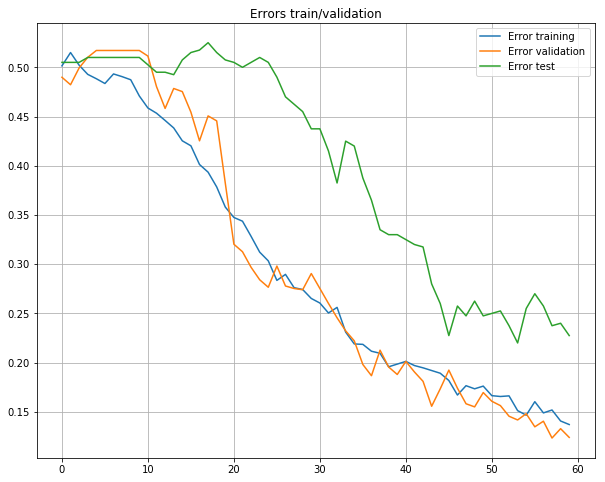

Error train: 0.160689170183
Error validation: 0.150506329114
Error test: 0.246
Dropout 0.8
ThreeCNNLayers(
  (sequential): Sequential(
    (0): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): Dropout(p=0.8)
    (4): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (5): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (6): ReLU()
    (7): Dropout(p=0.8)
    (8): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (9): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (10): ReLU()
    (11): Dropout(p=0.8)
    (12): Flatten(
    )
    (13): Linear(in_features=1232, out_features=200, bias=True)
    (14): ReLU()
    (15): Linear(in_features=200, out_features=2, bias=True)
  )
)


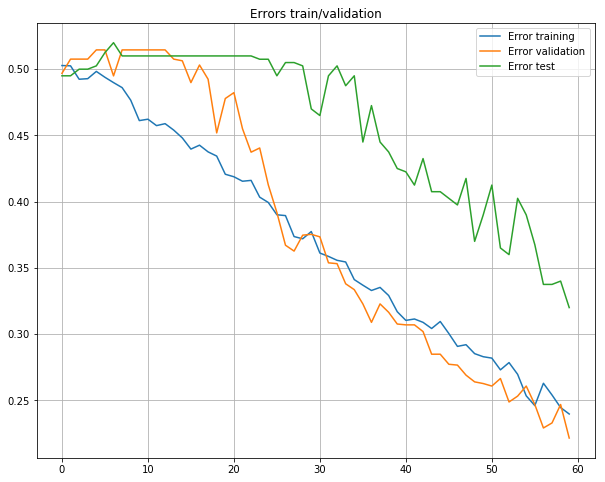

Error train: 0.270309423347
Error validation: 0.254430379747
Error test: 0.374
Dropout 0.9
ThreeCNNLayers(
  (sequential): Sequential(
    (0): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): Dropout(p=0.9)
    (4): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (5): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (6): ReLU()
    (7): Dropout(p=0.9)
    (8): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (9): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (10): ReLU()
    (11): Dropout(p=0.9)
    (12): Flatten(
    )
    (13): Linear(in_features=1232, out_features=200, bias=True)
    (14): ReLU()
    (15): Linear(in_features=200, out_features=2, bias=True)
  )
)


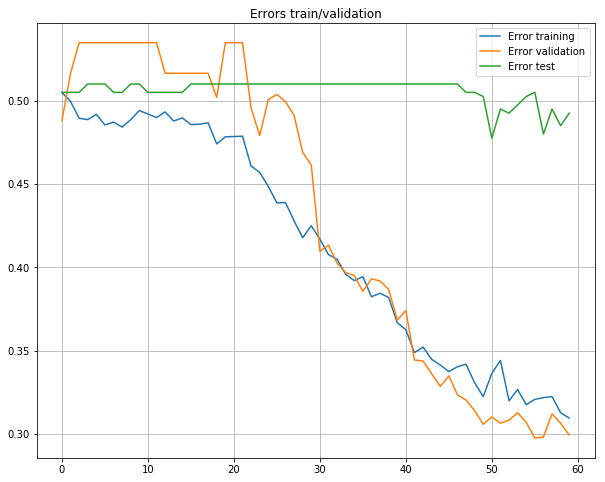

Error train: 0.326905766526
Error validation: 0.310379746835
Error test: 0.497


In [11]:
dropout_values=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results=[]
for dropout in dropout_values:
    print('Dropout',dropout)
    cv=CrossValidation(k=4,train_dataset=train_dataset,test_dataset=test_dataset,
                   train_target=train_target,test_target=test_target,cuda=True)
    
    net_type=ThreeCNNLayers
    optimizer_type=optim.Adam
    criterion_type=nn.CrossEntropyLoss
    network_params=NetworkParams(conv_filters=[28,28,28],conv_kernels=[3,3,3],
                                 linear_filters=[200,2],
                                 dropout_rate=dropout,batch_norm=True,conv1D=True)
    optimizer_params=OptimizerParams()
    train_params=TrainParams(max_epoch=60,mini_batch_size=79*5)


    params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,
                  optimizer_params=optimizer_params,train_params=train_params,cuda=True,plot=True)

    cv(params,repetitions=1,cross_validation=True,repetitions_test=4)
    results.append(cv.result)

In [ ]:
params.network

In [12]:
save=True
if save:
    file_name=folder.stored+'noise'
    write_pickle(results,file_name)

In [ ]:
cv=CrossValidation(k=2,train_dataset=train_dataset,test_dataset=test_dataset,
                   train_target=train_target,test_target=test_target)

net_type=ThreeLayers2D
optimizer_type=optim.Adam
criterion_type=nn.CrossEntropyLoss
network_params=NetworkParams(conv_filters=[28,28,28],conv_kernels=[(3,1),(5,3),(3,3)],
                             linear_filters=[200,2],
                             dropout_rate=0,batch_norm=False,conv1D=False)
optimizer_params=OptimizerParams()
train_params=TrainParams(max_epoch=100,mini_batch_size=79)


params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,
              optimizer_params=optimizer_params,train_params=train_params,)

cv(params)

In [ ]:
net_type=ThreeLayers
optimizer_type=optim.Adam
criterion_type=nn.CrossEntropyLoss
network_params=NetworkParams(linear_filters=[200,2],dropout_rate=0)
optimizer_params=OptimizerParams()
train_params=TrainParams(max_epoch=100)


params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,
              optimizer_params=optimizer_params,train_params=train_params,)

train=Train(train_dataset=train_dataset,test_dataset=test_dataset,
            train_target=train_target,test_target=test_target)
train(params)

In [ ]:
class ThreeLayers2D(nn.Module):
    
    num_my_conv_layers=2
    num_linear_layers=3
    
    def __init__(self,params):
        super(ThreeLayers2D,self).__init__()
        
        self.params=params
        
        layers=[]
        layers.append(Tensor4D())
        for i in range(self.num_my_conv_layers): 
            layers+=MyConv2D(*self.params[i]).layers
            
        layers.append(Flatten())
        layers.append(nn.Linear(*self.params[self.num_my_conv_layers]))
        layers.append(nn.BatchNorm1d(self.params[self.num_my_conv_layers][1]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.7))
        
        layers.append(nn.Linear(*self.params[self.num_my_conv_layers+1]))   
        layers.append(nn.BatchNorm1d(self.params[self.num_my_conv_layers+1][1]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0))
        
        layers.append(nn.Linear(*self.params[self.num_my_conv_layers+2]))
        
        self.sequential=nn.Sequential(*layers)
        
    def forward(self,x):
        x=self.sequential(x)
        
        return x
    
cv=CrossValidation(k=2,train_dataset=train_dataset,test_dataset=test_dataset,
                   train_target=train_target,test_target=test_target,cuda=True)

net_type=ThreeLayers2D
optimizer_type=optim.Adam
criterion_type=nn.CrossEntropyLoss
network_params=NetworkParams(conv_filters=[3,5], conv_kernels=[(1,5),(28,3)],
                             linear_filters=[100, 50, 2],
                             dropout_rate=0.7,batch_norm=True,conv1D=False)
optimizer_params=OptimizerParams()
train_params=TrainParams(max_epoch=1000,mini_batch_size=79*2)

params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,
              optimizer_params=optimizer_params,train_params=train_params,cuda=True)

cv(params, cross_validation=False, repetitions=1)